# Aim

Get used to loading Kepler data, and try IDEM.

IDEM as in Appendix A of Hsu 2018 (https://arxiv.org/pdf/1803.10787.pdf).

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from dev.completeness import *
from tqdm.notebook import tqdm
from os import path

%load_ext autoreload
%autoreload 2

In [3]:
stellar = pd.read_hdf('../data/q1_q16_stellar.h5')

In [4]:
planetary = pd.read_hdf('../data/q1_q16_koi.h5')

In [5]:
planetary = planetary[np.isfinite(planetary['koi_prad'])]

(array([  1.,   0.,   0.,   0.,   1.,   1.,   4.,   6.,   8.,  23.,  51.,
        101., 136., 233., 297., 378., 485., 495., 515., 511., 478., 450.,
        344., 219., 128., 113., 107.,  86.,  63.,  85.,  55.,  66.,  69.,
         63.,  70.,  55.,  61.,  71.,  89.,  84., 108.,  99., 108., 102.,
         95.,  91.,  56.,  58.,  40.,  39.,  18.,  23.,  22.,  13.,  20.,
         10.,  15.,   9.,   8.,   5.,   5.,   9.,   5.,   2.,   7.,   5.,
          4.,   2.,   1.,   6.,   5.,   5.,   2.,   5.,   5.,   1.,   5.,
          7.,   3.,   6.,   7.,   6.,   3.,   4.,   1.,   3.,   0.,   1.,
          2.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.96611286, -1.8304551 , -1.69479735, -1.55913959, -1.42348184,
        -1.28782408, -1.15216633, -1.01650857, -0.88085082, -0.74519306,
        -0.60953531, -0.47387755, -0.3382198 , -0.20256204, -0.06690429,
         0.06875347,  0.20441122,  0.34006898,  0.47572673,  0.61138449,
         0.74704224,  0.88

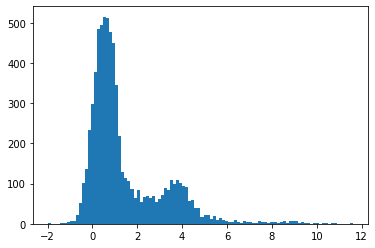

In [6]:
# let's group all these planets into buckets based on planet size and orbital period!
radii = np.array(planetary['koi_prad'])
plt.hist(np.log(radii), bins=100)

(array([  1.,   5.,   5.,   8.,  10.,  47.,  81.,  80.,  98.,  88., 153.,
         98., 146.,  85., 124., 119., 144., 140., 147., 176., 184., 200.,
        199., 209., 228., 218., 212., 186., 225., 237., 209., 216., 186.,
        193., 164., 154., 147., 125., 129., 129.,  96., 108.,  79.,  77.,
         93.,  72.,  79.,  75.,  66.,  69.,  80.,  77.,  53.,  78.,  52.,
        162.,  81.,  58.,  54.,  33.,   5.,   2.,   1.,   3.,   0.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.41946841, -1.28752115, -1.1555739 , -1.02362664, -0.89167938,
        -0.75973213, -0.62778487, -0.49583761, -0.36389036, -0.2319431 ,
        -0.09999584,  0.03195141,  0.16389867,  0.29584593,  0.42779318,
         0.55974044,  0.6916877 ,  0.82363495,  0.95558221,  1.08752947,
         1.21947672,  1.35

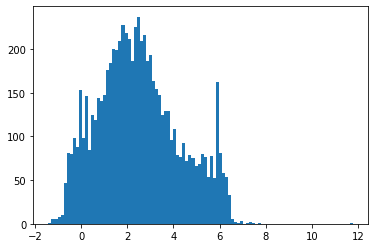

In [7]:
periods = np.array(planetary['koi_period'])
plt.hist(np.log(periods), bins=100)

Text(0, 0.5, 'Log-radius (ln Earth radii)')

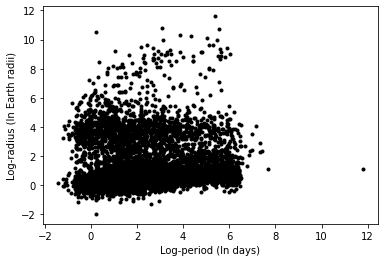

In [8]:
plt.plot(np.log(periods), np.log(radii), ".k")
plt.xlabel("Log-period (ln days)")
plt.ylabel("Log-radius (ln Earth radii)")

In [9]:
planetary = planetary[planetary['koi_disposition'] != "FALSE POSITIVE"]
combined = pd.merge(planetary, stellar, on="kepid")
rstars = combined['radius'].values 
mstars = combined['mass'].values
periods = combined['koi_period'].values
prads = combined['koi_prad'].values
eccs = combined['koi_eccen'].values

In [10]:
def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
		return (Go4pi*period*period*mstar) ** (1./3)
        
pgeoms = rstars / get_a(periods, mstars)

5531

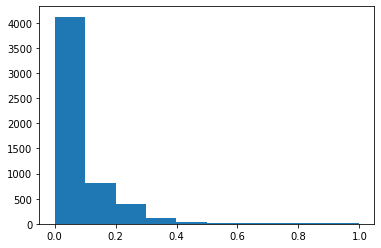

In [11]:
int(sum(plt.hist(pgeoms[(np.isfinite(pgeoms)) & (pgeoms <= 1.0)])[0]))

In [12]:
# these things should be an import from completeness.py
# except that this only uses pdet and not pwin

cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

def pdet_combined(catalog):
    return pcomp_vectors(catalog, catalog['koi_period'].values, 
                         catalog['koi_prad'].values, catalog['koi_eccen'].values)

def pdet_vectors(stars, periods, rp, eccs):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
    cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
    pgam = gamma(4.65, loc=0., scale=0.98)
    mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
    mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                            dtype=float)
    mstars = stars['mass'].values
    rstars = stars['radius'].values
    cdpp = stars[cdpp_cols].values
    dataspan = stars['dataspan'].values
    dutycycle = stars['dutycycle'].values
    mesthres_cols_stars = stars[mesthres_cols].values

    return pcomp_star_vectors(mstars, rstars, cdpp, dataspan, dutycycle, mesthres_cols_stars, periods, rp, eccs)

def pdet_star_vectors(mstars, rstars, cdpp, dataspan, dutycycle, mesthres_cols_stars, periods, rp, eccs):
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    # sigma = np.apply_along_axis(np.interp, 0, tau, cdpp_vals, cdpp)
    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    # Compute the radius ratio and estimate the S/N.
    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    
    return pdets

In [13]:
planetary_params = np.vstack((planetary.koi_period.values, 
                              planetary.koi_prad.values, planetary.koi_eccen.values)).T

In [14]:
if not path.exists('../data/idem_pdets_i.npy'):
    if not path.exists('../data/idem_pdets.npy'):
        pdet_ij = np.empty((len(planetary), len(stellar)))
        for i, params in enumerate(tqdm(planetary_params, total=len(planetary))):
            pdet_ij[i] = pcomp_vectors(stellar, *params)
        np.save('../data/idem_pdets.npy', pdet_ij)
    else:
        pdet_ij = np.load('../data/idem_pdets.npy')
    pdet_i = np.nanmean(pdet_ij, axis=1)
    np.save('../data/idem_pdets_i.npy', pdet_i)
else:
    pdet_i = np.load('../data/idem_pdet_i.npy')

(array([ 222.,  206.,  221.,  274.,  262.,  358.,  530., 1030., 1305.,
        1221.]),
 array([2.57040650e-04, 1.00231337e-01, 2.00205633e-01, 3.00179928e-01,
        4.00154224e-01, 5.00128520e-01, 6.00102816e-01, 7.00077112e-01,
        8.00051408e-01, 9.00025704e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

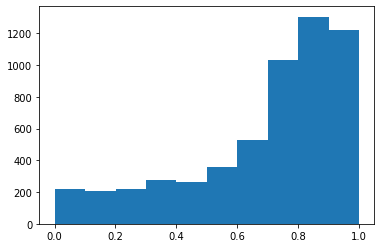

In [15]:
plt.hist(pdet_i)

In [16]:
weights = np.nan_to_num(1 / (pdet_i * pgeoms))

In [19]:
period_bins = np.array([0.1, 0.5, 1., 2., 4., 8., 16., 32., 64., 128., 256., 500.])
rp_bins = np.array([0.1, 0.5, 0.75, 1., 1.25, 1.5, 1.75, 2., 2.5, 3., 4., 6., 8., 12.])
counts = np.histogram2d(periods, prads, bins=[period_bins, rp_bins])[0]
N = np.histogram2d(periods, prads, bins=[period_bins, rp_bins], weights=weights)
f = N[0] / len(stellar)

Text(0, 0.5, 'Period (days)')

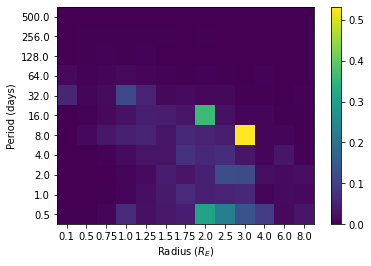

In [25]:
plt.imshow(f)
plt.colorbar()
_ = plt.xticks(list(range(len(rp_bins)-1)), rp_bins[:-1])
plt.xlabel(r"Radius ($R_E$)")
_ = plt.yticks(list(range(len(period_bins)-1)), period_bins[::-1])
plt.ylabel("Period (days)")

In [56]:
sigmas = np.divide(f, np.sqrt(counts), out=np.zeros_like(f), where=counts!=0)

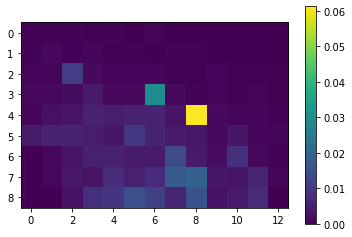

In [59]:
plt.imshow(sigmas)
plt.colorbar()